In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


### Helper functions

In [4]:
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date

# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

In [5]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [6]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})


In [105]:
# plot predictions and return a merged dataframe of all the predictions against the actual values
def plot_predictions(predictions, actual):
    pred_df = pd.DataFrame()
    pred_df['Actual'] = actual
    try:
        plt.figure(figsize=(12, 8))
        for idx, prediction in enumerate(predictions):
            plt.plot(prediction, label=f'Prediction-{idx+1}')
            pred_df[f'Prediction-{idx+1}'] = prediction
    except ValueError as e:
        print('Error:', e)

    print(pred_df)
    plt.plot(actual, label='Actual')
    plt.legend()
    plt.show()

    return pred_df


def plot_future(past, predicted, actual):
    plt.figure(figsize=(15, 8))
    plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=min(predictions_future.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')


In [118]:
def inverse_transform(X, scaler, features=15):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), features))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:,0]

## Data preprocessing and preparation


In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
# CONsTS
dataset = df.values  # get raw values from dataframe
TIMESTEPS = 30 # n days in the future to predcict
TRAIN_SIZE = int(len(dataset) * 0.75)  # 75% training set
TEST_SIZE = len(dataset) - TRAIN_SIZE  # 25% test set
FEATURES = 14  # number of features

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train, test = dataset[:TRAIN_SIZE, :], dataset[TRAIN_SIZE:len(dataset), :]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, TIMESTEPS)
testX, testY = create_dataset(test, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], TIMESTEPS, FEATURES))
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))

In [13]:
# Input shape for LSTM
input = (trainX.shape[1], trainX.shape[2])
input

(30, 14)

## Build and fit model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                20224     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 2s 91ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 2/20
26/26 [==============================] - 1s 19ms/step - loss: 3.7358e-04 - val_loss: 0.0024
Epoch 3/20
26/26 [==============================] - 1s 22ms/step - loss: 3.4916e-04 - val_loss: 8.7801e-04
Epoch 4/20
26/26 [==============================] - 1s 23ms/step - loss: 2.6659e-04 - val_loss: 0.0016
Epoch 5/20
26/26 [==============================] - 1s 25ms/step - loss: 2.2936e-04 - val_loss: 0.0010

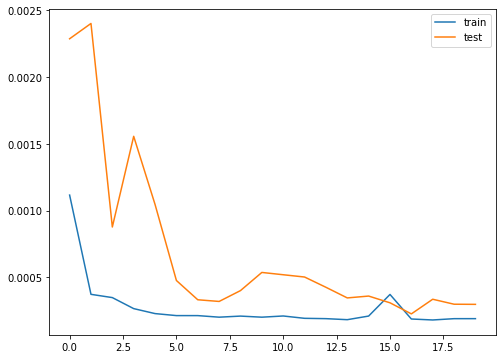

In [15]:
# model1
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=input))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
history = model.fit(trainX, trainY, validation_split=0.4, epochs=20, batch_size=32)

plot_history(history)

{'mape': '40.7%', 'me': -18170.935746394232, 'mae': 18236.858482547355, 'mpe': -0.4027430550014668, 'rmse': 19633.110998489985, 'corr': 0.9620550664313069, 'minmax': 0.4059905010389159}
           Actual  Prediction-1
0    13765.144079  10139.342187
1    13573.000000  10376.178434
2    14025.929379  10521.010535
3    14163.302878  10325.692771
4    15605.181292  10558.827519
..            ...           ...
421  50696.802160  28555.440980
422  47535.309698  28987.089518
423  46471.230000  29283.386568
424  47128.468155  28745.970676
425  46208.210437  27960.134437

[426 rows x 2 columns]


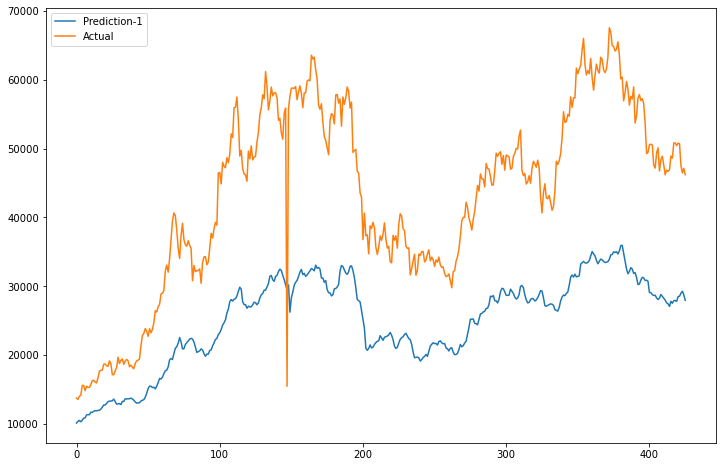

In [18]:
# make predictions: model 1
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform predictions
inv_train_yhat = inverse_transform(trainPredict, scaler)
inv_test_yhat = inverse_transform(testPredict, scaler)
test_period = df[-len(inv_test_yhat):].close.values

# accuracy metrics
print(forecast_accuracy(inv_test_yhat, test_period))

# plot predictions
predictions = plot_predictions([inv_test_yhat], test_period)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 128)           73216     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

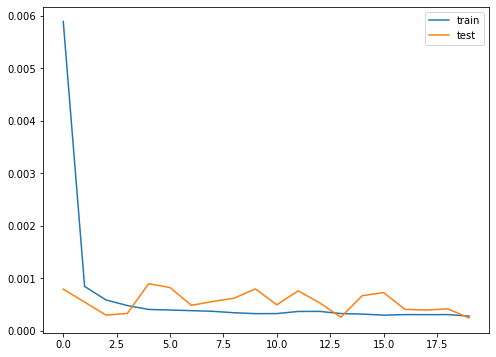

In [19]:
# model2
model2 = Sequential()
model2.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=input))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))  # Prediction of the next value

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

history2 = model2.fit(trainX, trainY, validation_split=0.3, epochs=20, batch_size=64)
plot_history(history2)

           Actual  Prediction-1  Prediction-2
0    13765.144079  10139.342187  12496.697671
1    13573.000000  10376.178434  12491.161342
2    14025.929379  10521.010535  12483.946404
3    14163.302878  10325.692771  12454.093614
4    15605.181292  10558.827519  12504.398182
..            ...           ...           ...
421  50696.802160  28555.440980  29955.465389
422  47535.309698  28987.089518  29970.653476
423  46471.230000  29283.386568  30021.953070
424  47128.468155  28745.970676  30096.480568
425  46208.210437  27960.134437  30185.607096

[426 rows x 3 columns]


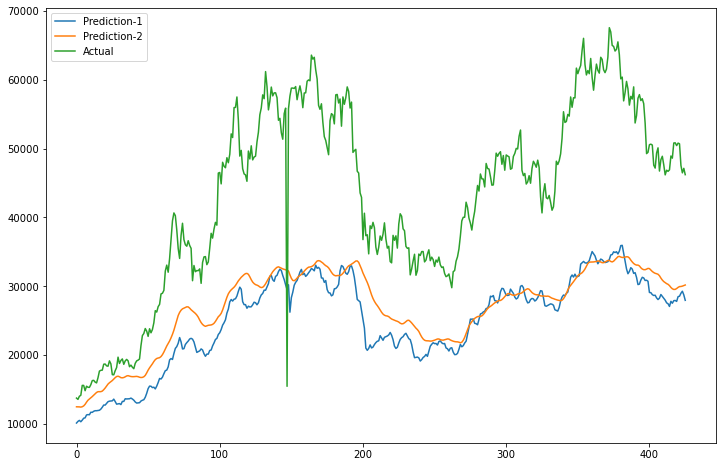

,Actual,Prediction-1,Prediction-2
0,13765.144079,10139.342187,12496.697671
1,13573.000000,10376.178434,12491.161342
2,14025.929379,10521.010535,12483.946404
3,14163.302878,10325.692771,12454.093614
4,15605.181292,10558.827519,12504.398182
...,...,...,...
421,50696.802160,28555.440980,29955.465389
422,47535.309698,28987.089518,29970.653476
423,46471.230000,29283.386568,30021.953070
424,47128.468155,28745.970676,30096.480568


In [20]:
# make predictions
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

# inverse
inv_train_yhat2 = inverse_transform(trainPredict2, scaler)
inv_test_yhat2 = inverse_transform(testPredict2, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2], df[-len(inv_test_yhat):].close.values)

Epoch 1/20
42/42 [==============================] - 2s 42ms/step - loss: 7.0292e-04 - val_loss: 0.1014
Epoch 2/20
42/42 [==============================] - 1s 20ms/step - loss: 2.7872e-04 - val_loss: 0.0595
Epoch 3/20
42/42 [==============================] - 1s 21ms/step - loss: 2.2773e-04 - val_loss: 0.0528
Epoch 4/20
42/42 [==============================] - 1s 20ms/step - loss: 2.3871e-04 - val_loss: 0.0361
Epoch 5/20
42/42 [==============================] - 1s 24ms/step - loss: 1.9956e-04 - val_loss: 0.0373
Epoch 6/20
42/42 [==============================] - 1s 20ms/step - loss: 1.8661e-04 - val_loss: 0.0279
Epoch 7/20
42/42 [==============================] - 1s 20ms/step - loss: 1.8727e-04 - val_loss: 0.0323
Epoch 8/20
42/42 [==============================] - 1s 20ms/step - loss: 2.0355e-04 - val_loss: 0.0354
Epoch 9/20
42/42 [==============================] - 1s 21ms/step - loss: 1.8037e-04 - val_loss: 0.0317
Epoch 10/20
42/42 [==============================] - 1s 21ms/step - loss:

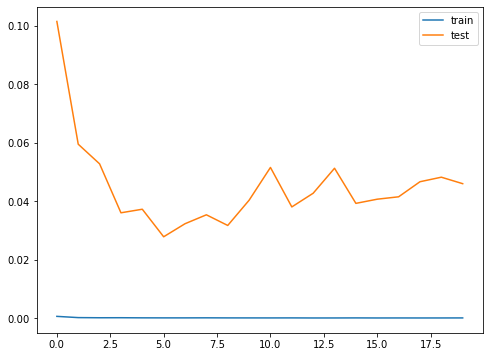

In [90]:
# model3: with validation input
model3 = Sequential()

model3.add(LSTM(64, activation='tanh', input_shape=input))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
# model3.summary()
history3 = model3.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=32)

plot_history(history3)

           Actual  Prediction-1  Prediction-2  Prediction-3
0    13765.144079  10139.342187  12496.697671  12249.405683
1    13573.000000  10376.178434  12491.161342  12336.770020
2    14025.929379  10521.010535  12483.946404  12429.535361
3    14163.302878  10325.692771  12454.093614  12475.380219
4    15605.181292  10558.827519  12504.398182  12790.958896
..            ...           ...           ...           ...
421  50696.802160  28555.440980  29955.465389  35572.482456
422  47535.309698  28987.089518  29970.653476  35101.006981
423  46471.230000  29283.386568  30021.953070  35237.047027
424  47128.468155  28745.970676  30096.480568  34670.845014
425  46208.210437  27960.134437  30185.607096  34028.567241

[426 rows x 4 columns]


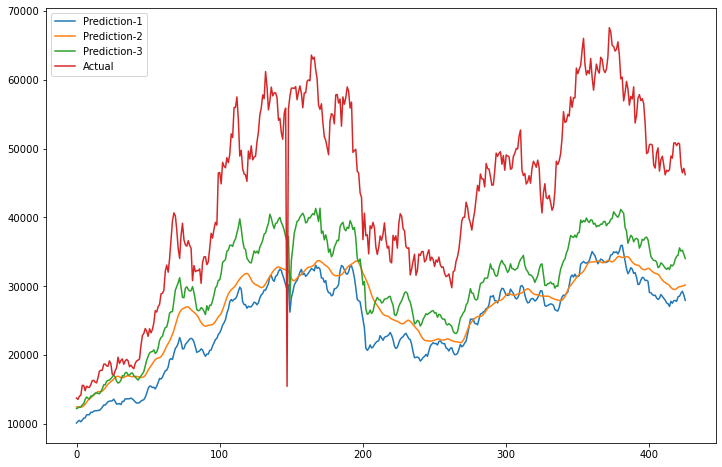

,Actual,Prediction-1,Prediction-2,Prediction-3
0,13765.144079,10139.342187,12496.697671,12249.405683
1,13573.000000,10376.178434,12491.161342,12336.770020
2,14025.929379,10521.010535,12483.946404,12429.535361
3,14163.302878,10325.692771,12454.093614,12475.380219
4,15605.181292,10558.827519,12504.398182,12790.958896
...,...,...,...,...
421,50696.802160,28555.440980,29955.465389,35572.482456
422,47535.309698,28987.089518,29970.653476,35101.006981
423,46471.230000,29283.386568,30021.953070,35237.047027
424,47128.468155,28745.970676,30096.480568,34670.845014


In [91]:
# make predictions
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

# inverse
inv_train_yhat3 = inverse_transform(trainPredict3, scaler)
inv_test_yhat3 = inverse_transform(testPredict3, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3], df[-len(inv_test_yhat):].close.values)

In [92]:
# accuracy comparisons
def pprint(d):
    for key, value in d.items():
        print(f"\t{key}: {value}")


print("Model 1:")
pprint(forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values))
print("Model 2:")
pprint(forecast_accuracy(inv_test_yhat2,
                         df[-len(inv_test_yhat2):].close.values))
print("Model 3:")
pprint(forecast_accuracy(inv_test_yhat3,
                         df[-len(inv_test_yhat3):].close.values))


Model 1:
	mape: 40.7%
	me: -18170.935746394232
	mae: 18236.858482547355
	mpe: -0.4027430550014668
	rmse: 19633.110998489985
	corr: 0.9620550664313069
	minmax: 0.4059905010389159
Model 2:
	mape: 34.873%
	me: -16270.92191882317
	mae: 16350.064392390419
	mpe: -0.3436148490076911
	rmse: 18331.26802114447
	corr: 0.9290660859223603
	minmax: 0.3473967288590879
Model 3:
	mape: 27.568%
	me: -12739.601067461326
	mae: 12838.538087642148
	mpe: -0.2692844507932047
	rmse: 14397.728551848955
	corr: 0.9589414285883069
	minmax: 0.2738356819474932


In [114]:
# model4 with limited features
top_predictors = ['close', 'open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df4 = df[top_predictors]

# normalize the dataset
scaler4 = MinMaxScaler(feature_range=(0, 1))
dataset4 = scaler4.fit_transform(df4.values)

# split into train and test sets
train4, test4 = dataset4[:TRAIN_SIZE, :], dataset4[TRAIN_SIZE:len(dataset4), :]

# reshape into X=t and Y=t+1
trainX4, trainY4 = create_dataset(train4, TIMESTEPS)
testX4, testY4 = create_dataset(test4, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX4 = np.reshape(trainX4, (trainX4.shape[0], TIMESTEPS, len(top_predictors)-1))
testX4 = np.reshape(testX4, (testX4.shape[0], TIMESTEPS, len(top_predictors)-1))


Epoch 1/20
42/42 [==============================] - 2s 51ms/step - loss: 0.0040 - val_loss: 0.0491
Epoch 2/20
42/42 [==============================] - 1s 27ms/step - loss: 2.9689e-04 - val_loss: 0.0143
Epoch 3/20
42/42 [==============================] - 1s 21ms/step - loss: 2.2809e-04 - val_loss: 0.0152
Epoch 4/20
42/42 [==============================] - 1s 21ms/step - loss: 2.2270e-04 - val_loss: 0.0125
Epoch 5/20
42/42 [==============================] - 1s 22ms/step - loss: 2.0148e-04 - val_loss: 0.0142
Epoch 6/20
42/42 [==============================] - 1s 26ms/step - loss: 1.9732e-04 - val_loss: 0.0084
Epoch 7/20
42/42 [==============================] - 1s 21ms/step - loss: 1.9549e-04 - val_loss: 0.0115
Epoch 8/20
42/42 [==============================] - 1s 21ms/step - loss: 1.8378e-04 - val_loss: 0.0098
Epoch 9/20
42/42 [==============================] - 1s 21ms/step - loss: 1.9222e-04 - val_loss: 0.0090
Epoch 10/20
42/42 [==============================] - 1s 21ms/step - loss: 1.7

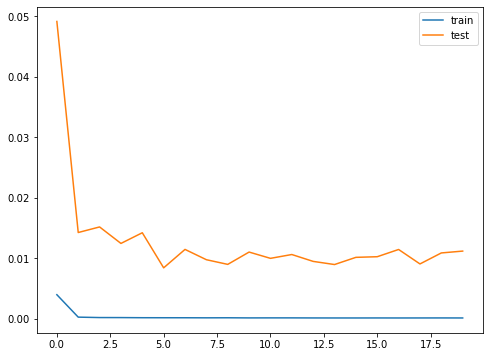

In [116]:
# model3: with validation input
model4 = Sequential()

model4.add(LSTM(64, activation='tanh', input_shape=(trainX4.shape[1], len(top_predictors)-1)))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
# model3.summary()
history4 = model4.fit(trainX4, trainY4, validation_data=(testX4, testY4), epochs=20, batch_size=32)

plot_history(history4)


           Actual  Prediction-1  Prediction-2  Prediction-3  Prediction-4
0    13765.144079  10139.342187  12496.697671  12249.405683  12468.691650
1    13573.000000  10376.178434  12491.161342  12336.770020  12666.986534
2    14025.929379  10521.010535  12483.946404  12429.535361  12864.561019
3    14163.302878  10325.692771  12454.093614  12475.380219  12867.786895
4    15605.181292  10558.827519  12504.398182  12790.958896  13095.831086
..            ...           ...           ...           ...           ...
421  50696.802160  28555.440980  29955.465389  35572.482456  42968.245011
422  47535.309698  28987.089518  29970.653476  35101.006981  43223.095221
423  46471.230000  29283.386568  30021.953070  35237.047027  43309.531197
424  47128.468155  28745.970676  30096.480568  34670.845014  42817.056679
425  46208.210437  27960.134437  30185.607096  34028.567241  42022.098036

[426 rows x 5 columns]


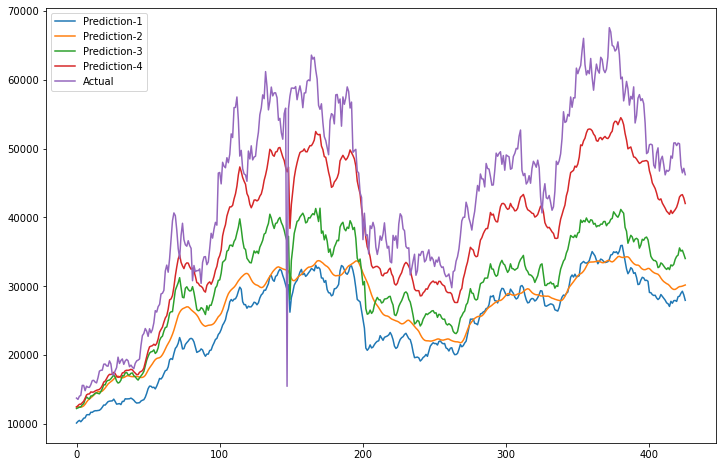

,Actual,Prediction-1,Prediction-2,Prediction-3,Prediction-4
0,13765.144079,10139.342187,12496.697671,12249.405683,12468.691650
1,13573.000000,10376.178434,12491.161342,12336.770020,12666.986534
2,14025.929379,10521.010535,12483.946404,12429.535361,12864.561019
3,14163.302878,10325.692771,12454.093614,12475.380219,12867.786895
4,15605.181292,10558.827519,12504.398182,12790.958896,13095.831086
...,...,...,...,...,...
421,50696.802160,28555.440980,29955.465389,35572.482456,42968.245011
422,47535.309698,28987.089518,29970.653476,35101.006981,43223.095221
423,46471.230000,29283.386568,30021.953070,35237.047027,43309.531197
424,47128.468155,28745.970676,30096.480568,34670.845014,42817.056679


In [120]:
# make predictions
trainPredict4 = model4.predict(trainX4)
testPredict4 = model4.predict(testX4)

# inverse
inv_train_yhat4 = inverse_transform(trainPredict4, scaler4, len(top_predictors))
inv_test_yhat4 = inverse_transform(testPredict4, scaler4, len(top_predictors))

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3, inv_test_yhat4], df[-len(inv_test_yhat):].close.values)


## Future predictions

In [24]:
yf_df = get_new_data('BTC-USD', '2020-12-31') 

In [101]:
# use saved model
from keras.models import load_model

saved_model = load_model('./model3-5.756.h5')
saved_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                20224     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(df.index[-1], periods=TIMESTEPS, freq='1d').tolist()

# make a prediction on based on the past 30 days
predictions_future3 = saved_model.predict(testX[-TIMESTEPS:])
predictions_future3 = inverse_transform(predictions_future3, scaler)
predictions_future = pd.DataFrame(predictions_future3, columns=['Prediction']).set_index(pd.Series(datelist_future))
predictions_future['Actual'] = yf_df.loc[min(predictions_future.index):max(predictions_future.index)].Close


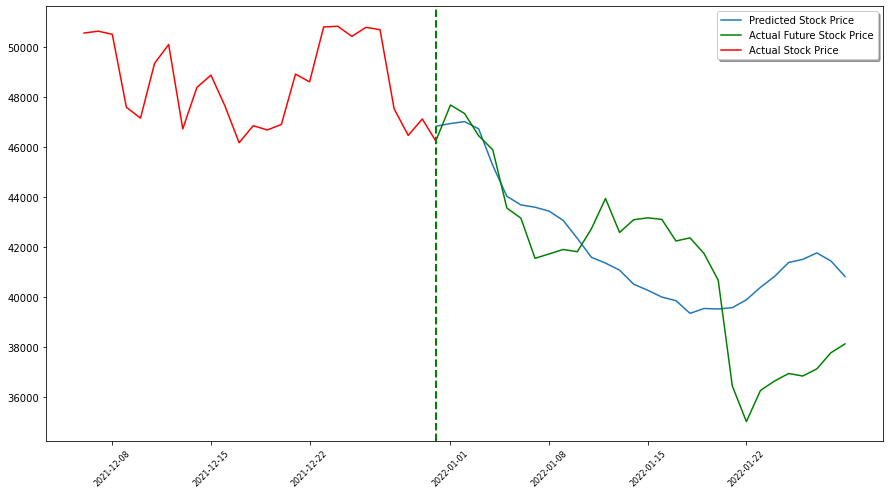

In [106]:
plot_future(df[1800:].close, predictions_future.Prediction, predictions_future.Actual)

{'mape': '5.756%',
 'me': 647.4932346887538,
 'mae': 2263.25784006576,
 'mpe': 0.019963293711888406,
 'rmse': 2696.1419799978044,
 'corr': 0.6668879528831748,
 'minmax': 0.05401480537417347}

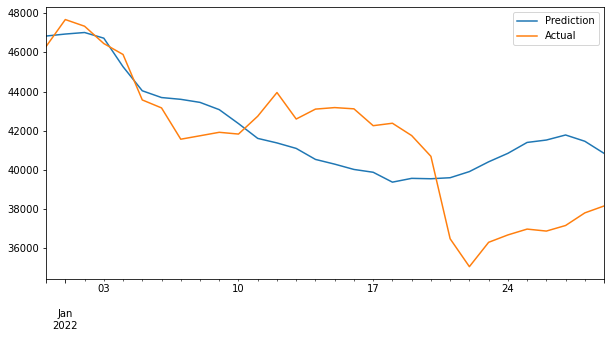

In [100]:
predictions_future.plot(figsize=(10, 5), label='Predicted Stock Price')
forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])

In [66]:
# save model with the MAPE score
mape = forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])['mape']
model3.save(f'model3-{str(mape).split("%")[0]}.h5')


In [121]:
# make a prediction on based on the past 30 days
predictions_future4 = model4.predict(testX4[-TIMESTEPS:])
predictions_future4 = inverse_transform(predictions_future4, scaler4, len(top_predictors))
predictions_future4 = pd.DataFrame(predictions_future4, columns=['Prediction']).set_index(pd.Series(datelist_future))
predictions_future4['Actual'] = yf_df.loc[min(predictions_future4.index):max(predictions_future4.index)].Close


In [123]:
mape = forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])['mape']
model4.save(f'model4-{str(mape).split("%")[0]}.h5')


{'mape': '6.712%',
 'me': 1835.9237634617791,
 'mae': 2615.7186362941507,
 'mpe': 0.04891196711509113,
 'rmse': 3285.0790020534187,
 'corr': 0.6342755128097716,
 'minmax': 0.060727409640340846}

{'mape': '6.712%',
 'me': 1835.9237634617791,
 'mae': 2615.7186362941507,
 'mpe': 0.04891196711509113,
 'rmse': 3285.0790020534187,
 'corr': 0.6342755128097716,
 'minmax': 0.060727409640340846}

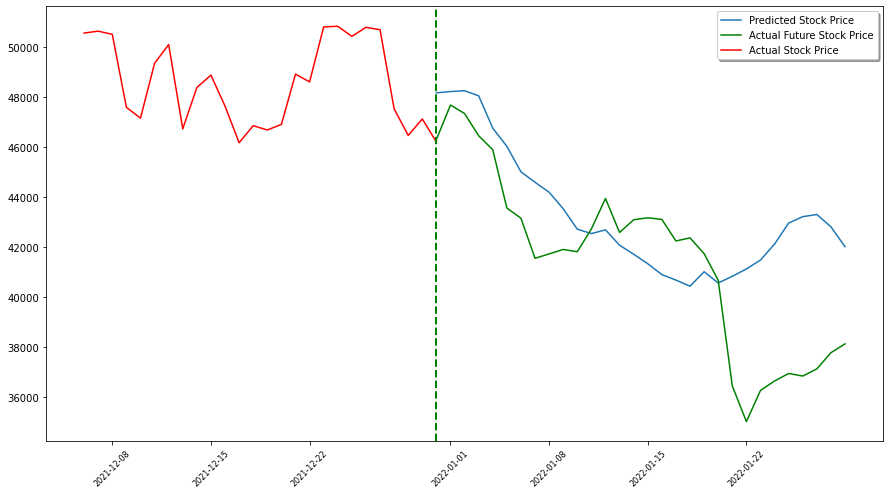

In [125]:
plot_future(df[1800:].close, predictions_future4.Prediction, predictions_future4.Actual)
forecast_accuracy(predictions_future4['Prediction'], predictions_future4['Actual'])
